#If Berlin Was Boston

In [1]:
# import libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters, parallel_coordinates, boxplot_frame, boxplot_frame_groupby
register_matplotlib_converters()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from helpers import price_parse, percent_parse, valid_value_intbool, multicategorical_to_dummies, make_dummies
import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8');

## Reading and Joining Data

In [2]:
# read data and join
#Boston
bos_lis = pd.read_csv('data/boston/listings.csv', sep=',', header=0,
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated',
                                 'calendar_last_scraped', 'first_review', 'last_review'],
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse,
                                'monthly_price': price_parse, 'security_deposit': price_parse,
                                'cleaning_fee': price_parse, 'extra_people': price_parse,
                                'host_acceptance_rate': percent_parse, 'host_response_rate': percent_parse},
                    true_values=['t'], false_values=['f'],
                    index_col='id')
#Berlin
ber_lis = pd.read_csv('data/berlin/listings_summary.csv', sep=',', header=0,
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated',
                                 'calendar_last_scraped', 'first_review', 'last_review'],
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse,
                                'monthly_price': price_parse, 'security_deposit': price_parse,
                                'cleaning_fee': price_parse, 'extra_people': price_parse,
                                'host_acceptance_rate': percent_parse, 'host_response_rate': percent_parse},
                    true_values=['t'], false_values=['f'],
                    index_col='id')

C:\Users\ruindur\.conda\envs\airbnb_blog\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (28,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Pre-Processing and Cleanup

In [3]:
# Pre-Process
# join in here to avoid problems with dropped columns upon re-running
listings = pd.concat([bos_lis.assign(**{'source': lambda x: 'Boston'}),
                      ber_lis.assign(**{'source': lambda x: 'Berlin'})], axis=0,
                     ignore_index=True, sort=False).dropna(how='all', axis=1)
# column categories
listings_categorical = ['experiences_offered', 'host_location', 'host_response_time',
                        'host_neighbourhood',
                        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
                        'state', 'zipcode', 'market', 'source', 'smart_location',
                        'property_type', 'cancellation_policy',
                        'room_type', 'bed_type', 'calendar_updated']
listings_presence = [] # to be filled later
listings_text = ['name', 'summary', 'space', 'description', 'notes', 'neighborhood_overview',
                 'transit', 'host_about', 'host_name', 'street', 'neighborhood']
listings_multi_categories = ['amenities'] #,'host_verifications']
listings_numeric = listings.select_dtypes('number').columns

# actual URLs are not interesting, but presence could be of value
for col in listings.columns:
    if 'url' in col:
        pcol = 'has_' + col
        listings[pcol] = listings[col].apply(valid_value_intbool, convert_dtype=True)
        listings.drop(col, axis=1, inplace=True)
        listings_presence.append(pcol)

# expand the selected multi-catergorical columns to dummy variables
for col in listings_multi_categories:
    multicat = multicategorical_to_dummies(listings[col])
    listings = listings.join(multicat)
    listings.drop(col, axis=1)

# remove columns where all values are the same
listings_all_same = []
for col in listings_categorical:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_categorical.remove(col)

for col in listings_presence:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_presence.remove(col)

for col in listings_numeric:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_numeric.remove(col)

listings = listings.drop(listings_all_same, axis=1)
# display for visual check
listings.sample(10)

,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,...,amenities_Wide clearance to shower,amenities_Wide doorway,amenities_Wide entryway,amenities_Wide hallway clearance,amenities_Wifi,amenities_Window guards,amenities_Wireless Internet,amenities_toilet,amenities_translation missing: en.hosting_amenity_49,amenities_translation missing: en.hosting_amenity_50
2909,20160906204935,2016-09-07,Minshu's Boston room by subway,Great bedroom (Minshu's room) with full size b...,Beautiful warm and inviting apartment decorate...,Great bedroom (Minshu's room) with full size b...,"The neighborhood is convenient, diverse, safe ...",Thank you for treating my home as you would yo...,Very easy and convenient commute. The home is ...,"Guests have access to kitchen, living room and...",...,0,0,0,0,0,0,1,0,1,1
20264,20181107122246,2018-11-07,"Entire studio, not a room","Private space in a good and quiet area, near C...",NaN,"Private space in a good and quiet area, near C...",NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
9109,20181107122246,2018-11-07,Nice Room in East Berlin for 1-2ppl,"Hi everyone, this cute room in eastern Berlin ...",NaN,"Hi everyone, this cute room in eastern Berlin ...",NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
3249,20160906204935,2016-09-07,Quarters on Dot - hostel-style unit,The STRB Quarters™ on DOT were completed in Ju...,"This unit features composite wood-flooring, a ...",The STRB Quarters™ on DOT were completed in Ju...,The location could not be more perfect with al...,The Quarters are designed to be interchangeabl...,Logan Airport is 5 minute taxi ride; Harvard U...,This unit is accessed using stairs (there is n...,...,0,0,0,0,0,0,1,0,0,0
21715,20181107122246,2018-11-07,sunny apartment @ Tempelhofer field,Cosy stylish 2 room Apartment with lots of lig...,NaN,Cosy stylish 2 room Apartment with lots of lig...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
23919,20181107122246,2018-11-07,Feeling like home in the heart of Berlin,NaN,Welcome to your typical Berlin apartment. You’...,Welcome to your typical Berlin apartment. You’...,The neighborhood is very popular and colourful...,Please don't smoke inside the apartment. You c...,Two Tram-lines crossing right infront of the d...,You can use the whole flat.,...,0,0,0,0,1,0,0,0,0,0
19381,20181107122246,2018-11-07,Gemütliche Wohnung in Berlin-Friedrichshain,Die Wohnung liegt im Herzen von Berlin-Friedri...,NaN,Die Wohnung liegt im Herzen von Berlin-Friedri...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
6719,20181107122246,2018-11-07,Helle Altbauwohnung Friedrichshain,NaN,Wohnzimmer Küche Bad U5 Frankfurter Tor (dami...,Wohnzimmer Küche Bad U5 Frankfurter Tor (dami...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
7567,20181107122246,2018-11-07,Wohnung direkt am Wasser nur ca 15 Min vom Ku'...,Schön möblierte Wohnung mit Pantry-Küche und D...,Die beiden angebotenen Wohnungen (eine 1-Zimme...,Schön möblierte Wohnung mit Pantry-Küche und D...,"Der Teil von Berlin, in dem die Wohnung liegt ...","WICHTIG: Bei ""Ausstattungsmerkmalen"" ist heir ...",Es gibt eine Bushaltestelle fast direkt vor de...,"Es gibt zwei separate Wohnungen, die vermietet...",...,0,0,0,0,1,0,0,0,0,0
22092,20181107122246,2018-11-07,Green Oasis Berlin,Little apartement in the city center of Berlin...,"37 km2 Many plants, so if you stay longer be k...",Little apartement in the city center of Berlin...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0


## Average Listing Properties by Neighbourhood
### Column Selection for Averaging

In [4]:
# no id columns here, no scrape metadata
aggregateable_cols = list(listings.columns)

# removing some columns that seem not useful
for col in listings.columns:
    if '_id' in col or 'scrape' in col:
        aggregateable_cols.remove(col)

# exclude columns that are uninterpretable or
exclude_columns = ['latitude', 'longitude', # purely geographic analysis
                   'amenities_', # artifact from multi-categorical expansion
                   'amenities_translation missing: en.hosting_amenity_49', # impossible to interpret
                   'amenities_translation missing: en.hosting_amenity_50', # impossible to interpret
                   'host_neighbourhood', # more interesting to check if host lives in same neighborhood as listing
                   'host_location', 'smart_location', # too spammy
                   'neighbourhood_cleansed', # too much correlationm to neighborhood
                   'neighbourhood_group_cleansed', # same, maybe use as replacement for neighbourhood
                   'market', 'source', # will only create distance between Boston and Berlin neighbourhoods
                   'calendar_updated', # metadata, not descriptive of listing
                   'city', 'state', 'zipcode', 'country', 'country_code', 'street' # more geographic features
                   ]

for col in exclude_columns:
    if col in aggregateable_cols:
        aggregateable_cols.remove(col)

dummy_cols = []
num_cols = []
for col in aggregateable_cols:
    if col in listings_categorical:
        dummy_cols.append(col)
    else:
        num_cols.append(col)
# output list of selected columns
print(*aggregateable_cols, sep=',\n')

name,
summary,
space,
description,
neighborhood_overview,
notes,
transit,
access,
interaction,
house_rules,
host_name,
host_since,
host_about,
host_response_time,
host_response_rate,
host_acceptance_rate,
host_is_superhost,
host_listings_count,
host_total_listings_count,
host_verifications,
host_has_profile_pic,
neighbourhood,
is_location_exact,
property_type,
room_type,
accommodates,
bathrooms,
bedrooms,
beds,
bed_type,
amenities,
square_feet,
price,
weekly_price,
monthly_price,
security_deposit,
cleaning_fee,
guests_included,
extra_people,
minimum_nights,
maximum_nights,
has_availability,
availability_30,
availability_60,
availability_90,
availability_365,
number_of_reviews,
first_review,
last_review,
review_scores_rating,
review_scores_accuracy,
review_scores_cleanliness,
review_scores_checkin,
review_scores_communication,
review_scores_location,
review_scores_value,
requires_license,
license,
instant_bookable,
cancellation_policy,
require_guest_profile_picture,
require_guest_phone_

## Average Listing Properties by Neighbourhood
### Normalize across whole data set

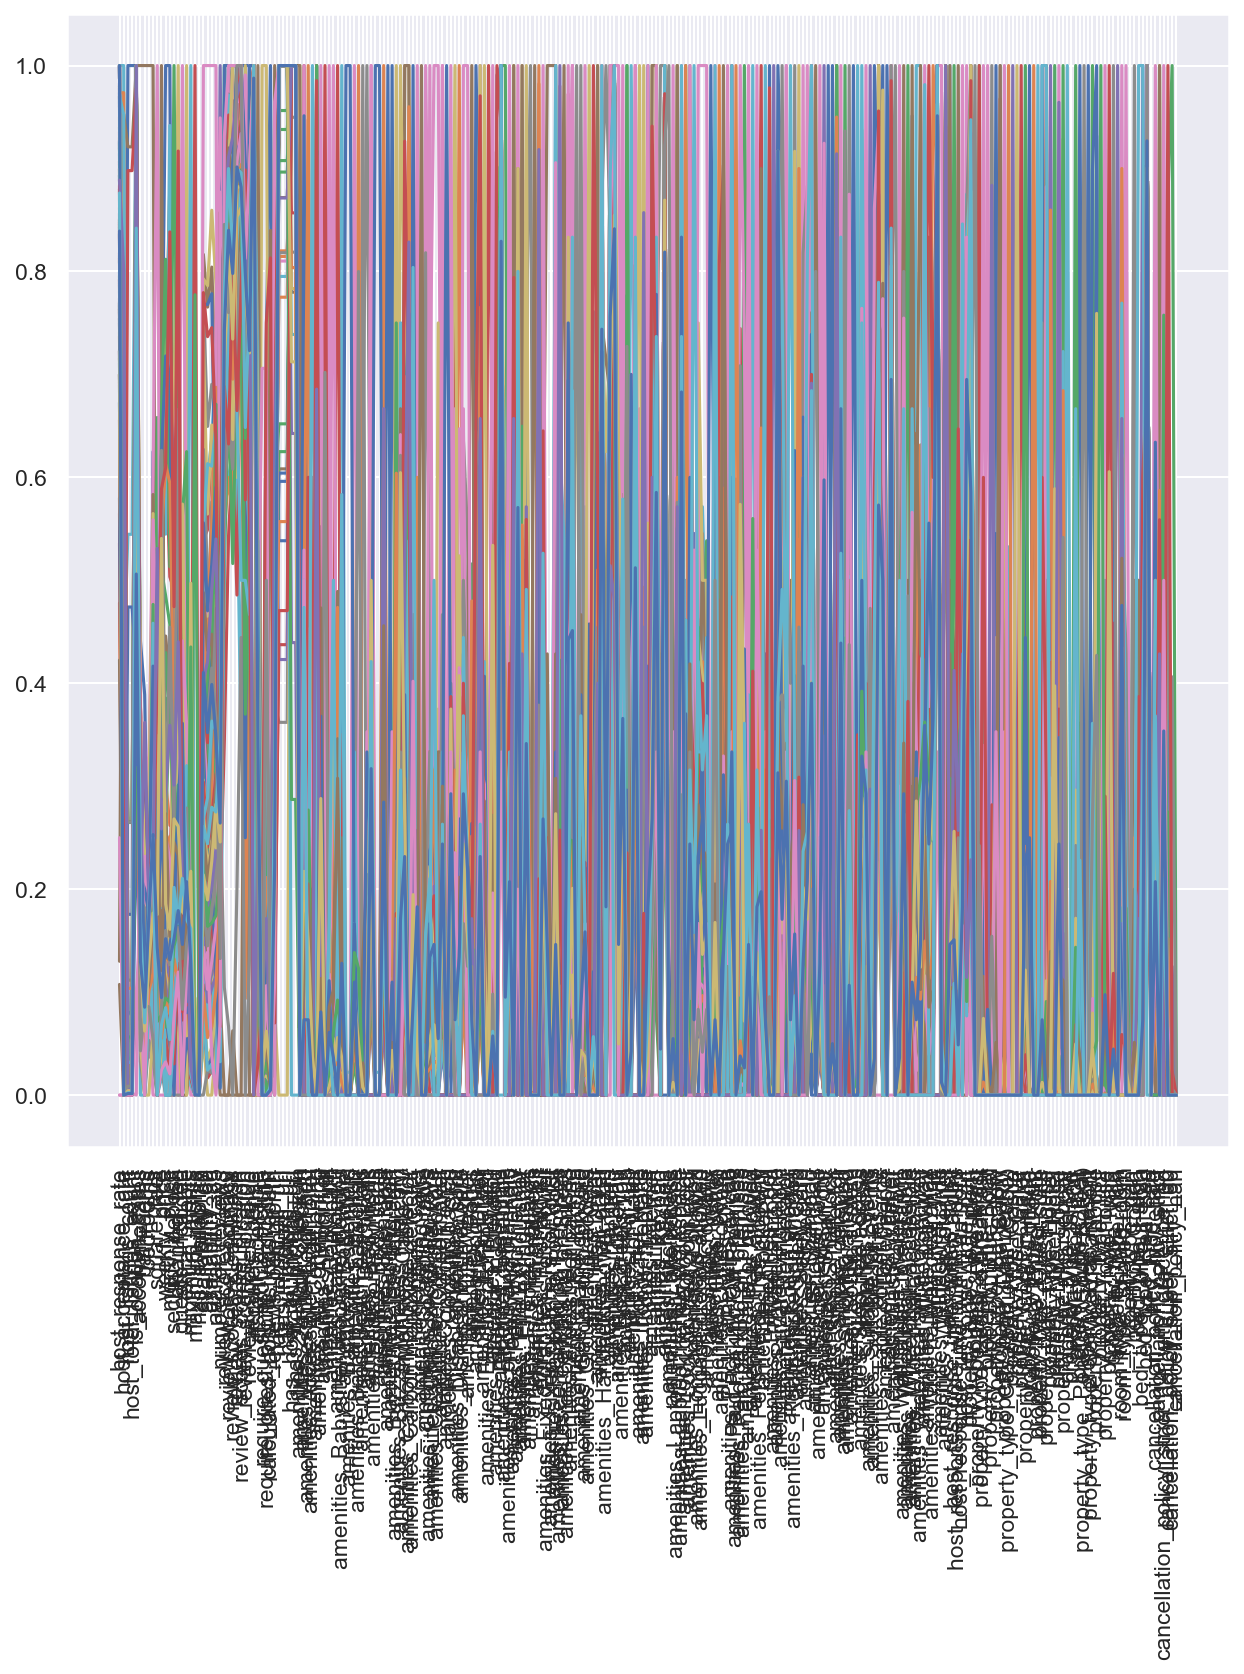

In [5]:
nbh_mean = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left') .groupby(['neighbourhood',]).mean()
nbh_mean_norm = nbh_mean.apply(lambda col: (col - col.min()) / (col.max() - col.min()))
plt.figure(figsize=(10,10), dpi=150)

# parallel coordinates plot to visually check if sufficient variability exists for meaningful grouping
for nbh in nbh_mean_norm.index:
    plt.plot(nbh_mean_norm.columns, nbh_mean_norm.fillna(0).loc[nbh], label=nbh)
plt.xticks(rotation=90);

In [6]:
print(nbh_mean.columns, sep=',\n')

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet',
       ...
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'bed_type_nan', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'cancellation_policy_nan'],
      dtype='object', length=253)


In [7]:
# get numbers of neighbourhoods per city
nbh_counts = listings.groupby('source')['neighbourhood'].value_counts()
ber_nbh_count = nbh_counts['Berlin'].index.shape[0]
ber_nbh_nam = list(nbh_counts['Berlin'].index)
bos_nbh_count = nbh_counts['Boston'].index.shape[0]
bos_nbh_nam = list(nbh_counts['Boston'].index)
print('Neighbourhoods in Boston: {}  | in Berlin {}'.format(bos_nbh_count, ber_nbh_count))

Neighbourhoods in Boston: 30  | in Berlin 91


### Normalize Grouped by City

In [8]:
nbh_mean_relative = nbh_mean.loc[ber_nbh_nam].apply(lambda col: (col - col.min()) / (col.max() - col.min()))
nbh_mean_relative = pd.concat((nbh_mean_relative,
                               nbh_mean.loc[bos_nbh_nam].apply(lambda col: (col - col.min()) / (col.max() - col.min()))))

nbh_mean_relative.sample(20)

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Niederschönhausen,0.672432,NaN,0.001637,0.001637,0.618644,0.385370,0.232446,0.654854,0.576271,0.098378,...,0.000000,0.101695,0.949153,NaN,0.338983,NaN,0.220339,0.000000,0.0,NaN
Wannsee,1.000000,NaN,1.000000,1.000000,0.416667,0.614035,0.285714,0.636364,0.666667,0.130088,...,0.000000,0.000000,1.000000,NaN,0.222222,NaN,0.444444,0.000000,0.0,NaN
Gatow,0.900000,NaN,0.003578,0.003578,0.750000,0.157895,0.000000,0.636364,0.200000,NaN,...,0.000000,0.000000,1.000000,NaN,0.166667,NaN,0.500000,0.000000,0.0,NaN
Heiligensee,1.000000,NaN,0.004391,0.004391,1.000000,0.660287,0.311688,0.735537,0.763636,NaN,...,0.000000,0.000000,1.000000,NaN,0.272727,NaN,0.272727,0.000000,0.0,NaN
Baumschulenweg,0.833714,NaN,0.001047,0.001047,0.542683,0.103979,0.167247,0.290466,0.200000,0.523894,...,0.000000,0.219512,0.890244,NaN,0.292683,NaN,0.195122,0.000000,0.0,NaN
Neukölln,0.715581,NaN,0.002598,0.002598,0.619508,0.120451,0.085875,0.350285,0.161149,0.156616,...,0.093487,0.091617,0.899969,NaN,0.312247,NaN,0.222811,0.002026,0.0,NaN
Halensee,0.907097,NaN,0.009481,0.009481,0.600000,0.194737,0.242857,0.357576,0.280000,0.200000,...,0.000000,0.100000,0.950000,NaN,0.250000,NaN,0.183333,0.000000,0.0,NaN
Alt-Hohenschönhausen,0.795769,NaN,0.012880,0.012880,0.550000,0.328421,0.308571,0.403636,0.408000,0.173894,...,0.000000,0.000000,1.000000,NaN,0.200000,NaN,0.260000,0.130000,0.0,NaN
Downtown,0.926108,0.359684,0.008601,0.008601,1.000000,0.338710,0.125000,0.000000,0.129032,NaN,...,0.000000,0.000000,1.000000,NaN,0.000000,0.750000,NaN,0.000000,NaN,NaN


## Comparing Neighourhoods by Properties
### Normalized Globally

In [10]:
print(*list(nbh_mean.columns), sep='\n')


host_response_rate
host_acceptance_rate
host_listings_count
host_total_listings_count
is_location_exact
accommodates
bathrooms
bedrooms
beds
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
requires_license
instant_bookable
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
reviews_per_month
has_thumbnail_url
has_medium_url
has_xl_picture_url
has_host_thumbnail_url
has_host_picture_url
amenities_24-Hour Check-in
amenities_24-hour check-in
amenities_Accessible-height bed
amenities_Accessible-height toilet
amenities_Air Conditioning
amenities_Air conditioning
amenities_Air purifier
amenities_BBQ grill
am

In [11]:
# distance matrix for comparison
disfr = pd.DataFrame(index=nbh_mean_norm.loc[ber_nbh_nam].index)
for cindex, cvals in nbh_mean_norm.loc[bos_nbh_nam].iterrows():
    disfr[cindex] = nbh_mean_norm.loc[ber_nbh_nam].apply(lambda x: np.sqrt(np.sum(np.power(x - cvals.values, 2))),
                                                         axis='columns')
# for heatmap, order rows and columns to have smallest distances top and left
disfr['rowmin'] = disfr.min(axis=1)
disfr.loc['colmin'] = disfr.min(axis=0)
disfr.sort_values(by='rowmin', axis=0, inplace=True)
disfr.sort_values(by='colmin', axis=1, inplace=True)
disfr.drop('rowmin', axis=1, inplace=True)
disfr.drop('colmin', axis=0, inplace=True)

In [12]:
disfr.head(125)


,Roxbury,Allston-Brighton,Dorchester,Somerville,Mission Hill,Hyde Park,Beacon Hill,Charlestown,East Boston,Jamaica Plain,...,Theater District,Financial District,Downtown,Cambridge,Leather District,Downtown Crossing,Chinatown,West End,Harvard Square,Government Center
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Grünau,3.503528,3.573873,3.568362,3.641926,3.628439,3.710053,3.739248,3.760516,3.804246,3.780230,...,4.163240,4.270922,4.310174,4.535508,4.622122,4.681304,4.909323,5.023425,5.260916,6.021689
Tempelhof,3.538293,3.539580,3.602395,3.645163,3.625354,3.772592,3.720945,3.775894,3.784485,3.805250,...,4.050689,4.212982,4.293605,4.584638,4.596371,4.589729,4.860989,4.978911,5.187930,5.940289
Baumschulenweg,3.591548,3.587085,3.595715,3.612493,3.655294,3.770981,3.767750,3.809480,3.765719,3.790678,...,4.131937,4.259126,4.348819,4.629273,4.615069,4.629824,4.939034,5.063731,5.282368,6.001504
Neukölln,3.647823,3.609287,3.689358,3.697255,3.700298,3.871232,3.786804,3.873752,3.883917,3.896785,...,4.164898,4.306484,4.388249,4.705156,4.663942,4.695962,4.990484,5.102995,5.306491,6.052510
Alt-Treptow,3.702529,3.649894,3.729743,3.780778,3.732917,3.918985,3.810103,3.871600,3.894885,3.899858,...,4.176430,4.310852,4.421586,4.745567,4.646136,4.658114,4.977387,5.083004,5.264586,6.016731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Karow,5.517109,5.638976,5.560572,5.696316,5.766609,5.595618,5.819869,5.669938,5.655999,5.652556,...,6.034389,6.087412,6.165012,6.310460,6.239479,6.385981,6.431107,6.517708,6.826700,7.206818
Haselhorst,5.690229,5.846997,5.770756,5.790868,6.007663,5.862447,5.907356,5.854687,5.694139,5.872448,...,6.196741,6.278523,6.281421,6.427871,6.314767,6.359241,6.597572,6.787731,6.994807,7.388941
Falkenberg,5.799958,5.817294,5.843918,5.871160,5.862820,5.924955,5.952150,5.893046,5.863614,5.960798,...,6.095540,6.261925,6.290996,6.259732,6.395110,6.367136,6.336805,6.483164,6.780233,7.178764


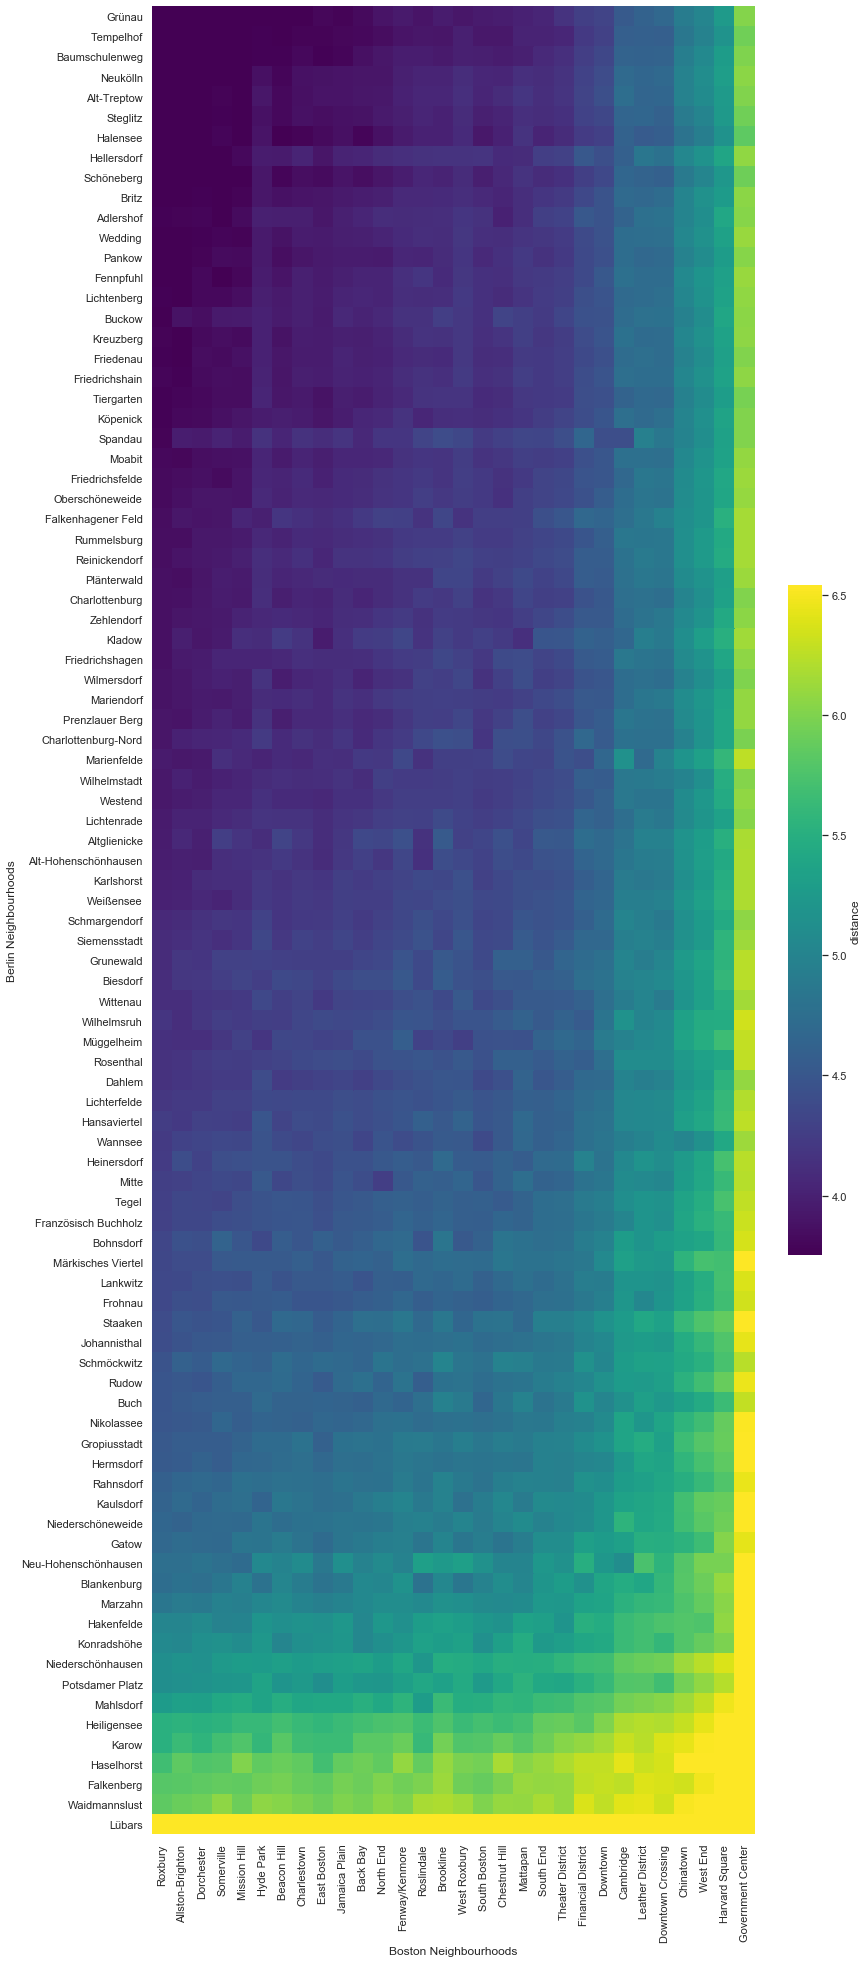

In [13]:
fix, ax = plt.subplots(figsize=(12,36))
sns.heatmap(disfr, annot=False, ax=ax, cmap='viridis', square=True, robust=True, cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
ax.set_xlabel('Boston Neighbourhoods')
ax.set_ylabel('Berlin Neighbourhoods')
plt.savefig('output/similarity_heatmap.png', bbox_inches='tight')

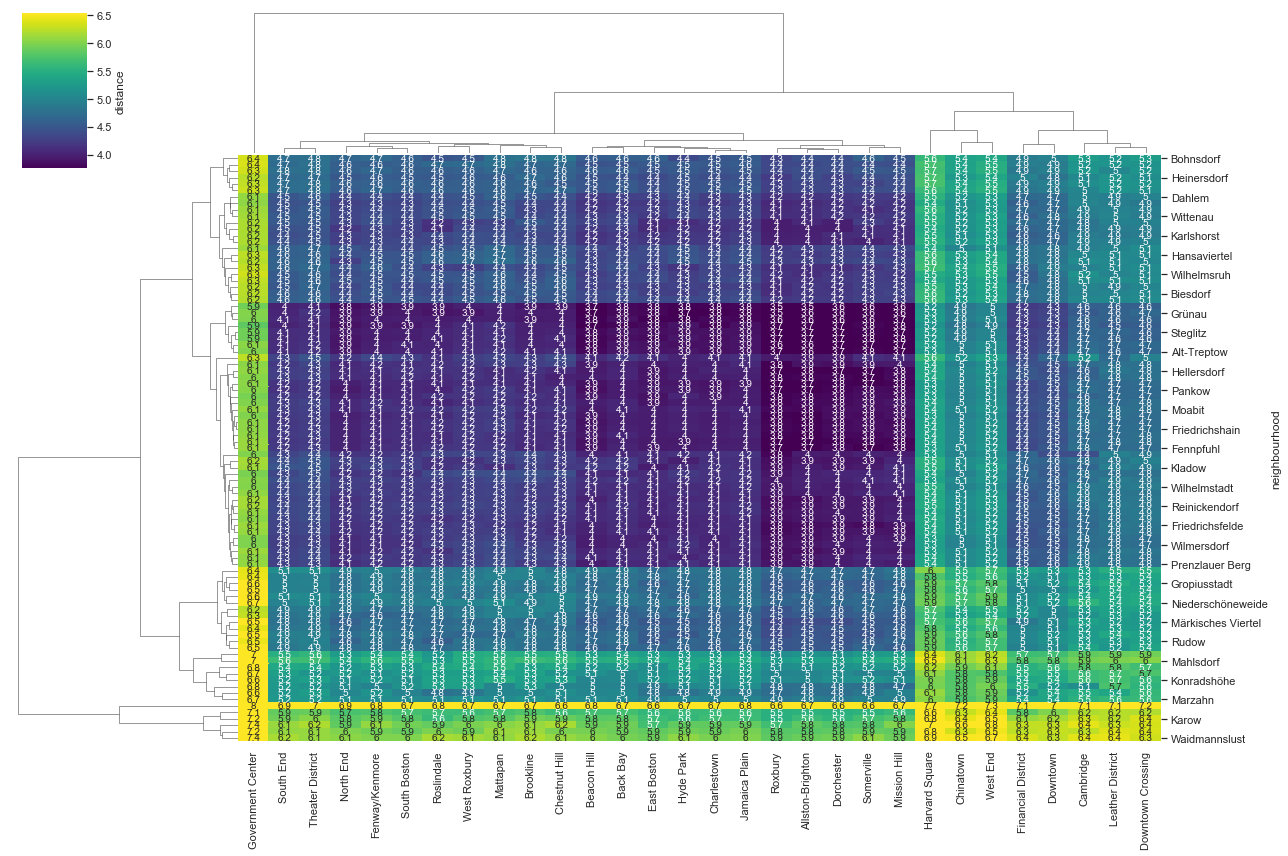

In [14]:
cgrid = sns.clustermap(disfr, annot=False, cmap='viridis', robust=True, figsize=(18,12), cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
plt.savefig('output/similarity_clustermap.png', bbox_inches='tight')

In [15]:
closest = pd.DataFrame(disfr.min(axis=0), columns=['distance'])
closest['neighbourhood'] = disfr.idxmin(axis=0)
closest['sigma'] = disfr.std(axis=0)
closest.sort_values(by='neighbourhood', ascending=True, inplace=True)
closest.head(30)

,distance,neighbourhood,sigma
Somerville,3.612493,Baumschulenweg,0.590799
East Boston,3.765719,Baumschulenweg,0.549517
Mattapan,3.997293,Baumschulenweg,0.534375
Roxbury,3.503528,Grünau,0.588984
Dorchester,3.568362,Grünau,0.584180
Hyde Park,3.710053,Grünau,0.564341
Charlestown,3.760516,Grünau,0.563414
Jamaica Plain,3.780230,Grünau,0.562998
Roslindale,3.902181,Grünau,0.536147
West Roxbury,3.925591,Grünau,0.528299


In [16]:
# count occurrences of Berlin neighbourhoods to assess similarity
closest['neighbourhood'].value_counts()

Tempelhof         10
Halensee           9
Grünau             7
Baumschulenweg     3
Spandau            1
Name: neighbourhood, dtype: int64

In [35]:
# average similarity per Berlin Neighborhood to assess "Bostonness"
print(disfr.mean(axis=1).sort_values().to_string(max_rows=None))
print(disfr.min(axis=1).sort_values().to_string(max_rows=None))


neighbourhood
Tempelhof               4.113126
Grünau                  4.131900
Baumschulenweg          4.151153
Halensee                4.156980
Schöneberg              4.194164
Steglitz                4.196302
Neukölln                4.212394
Alt-Treptow             4.227611
Britz                   4.254718
Pankow                  4.262643
Tiergarten              4.281552
Wedding                 4.288092
Friedenau               4.293821
Adlershof               4.300794
Hellersdorf             4.300922
Fennpfuhl               4.301324
Köpenick                4.306733
Kreuzberg               4.307247
Lichtenberg             4.307447
Friedrichshain          4.311725
Moabit                  4.340499
Buckow                  4.340554
Charlottenburg          4.361645
Friedrichsfelde         4.366671
Wilmersdorf             4.379357
Oberschöneweide         4.380443
Zehlendorf              4.389822
Plänterwald             4.398415
Spandau                 4.405107
Prenzlauer Berg         4.405

## Normalized by City

In [17]:
# distance matrix for comparison
dis_rel = pd.DataFrame(index=nbh_mean_relative.loc[ber_nbh_nam].index)
for cindex, cvals in nbh_mean_relative.loc[bos_nbh_nam].iterrows():
    dis_rel[cindex] = nbh_mean_relative.loc[ber_nbh_nam].apply(
        lambda x: np.sqrt(np.sum(np.power(x - cvals.values, 2))), axis='columns')
# for heatmap, order rows and columns to have smallest distances top and left
dis_rel['rowmin'] = dis_rel.min(axis=1)
dis_rel.loc['colmin'] = dis_rel.min(axis=0)
dis_rel.sort_values(by='rowmin', axis=0, inplace=True)
dis_rel.sort_values(by='colmin', axis=1, inplace=True)
dis_rel.drop('rowmin', axis=1, inplace=True)
dis_rel.drop('colmin', axis=0, inplace=True)
dis_rel.head(125)

,Beacon Hill,South Boston,South End,Allston-Brighton,Brookline,Mission Hill,Back Bay,Fenway/Kenmore,Charlestown,Theater District,...,Jamaica Plain,Financial District,Chestnut Hill,Mattapan,Leather District,Harvard Square,Cambridge,Chinatown,Government Center,West End
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Prenzlauer Berg,1.519248,1.696463,1.715627,1.936558,2.156936,2.061146,2.052931,2.083936,2.074734,2.137515,...,2.604250,2.533446,2.754254,3.069021,2.783240,3.192239,3.222668,3.386090,3.526628,3.524449
Schöneberg,1.561198,1.664407,1.730717,1.907310,2.051267,2.015680,2.042184,2.038845,2.061124,2.115861,...,2.548263,2.438584,2.710832,2.957900,2.801450,3.159858,3.199498,3.368760,3.463271,3.499400
Charlottenburg,1.582531,1.616284,1.697665,1.862412,1.983912,1.987866,2.037957,2.000705,2.056089,2.026203,...,2.582339,2.448275,2.626003,2.918729,2.783022,3.109598,3.079362,3.278642,3.345849,3.401587
Buckow,1.597956,1.765892,1.718200,2.097686,2.258656,2.199702,2.113103,2.251144,2.059814,2.323102,...,2.639342,2.576851,3.036458,2.943685,2.899913,3.403137,3.123410,3.375993,3.621186,3.493641
Kreuzberg,1.610851,1.855493,1.819376,1.875406,2.167253,1.995817,2.179915,2.175405,2.137343,2.232522,...,2.592263,2.571655,2.757206,3.000194,2.860775,3.373937,3.338268,3.538338,3.681148,3.650572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Waidmannslust,3.412655,2.923299,3.276379,3.032544,3.515011,3.149595,3.114701,3.262100,3.424170,3.003355,...,3.361574,3.868240,3.760855,3.579278,3.755622,3.900060,3.899046,4.096958,4.117776,4.318242
Lübars,3.576089,3.127625,3.511895,3.326907,2.871336,3.423734,3.612561,3.418112,3.553641,3.642406,...,3.669279,3.907556,2.906013,3.291178,3.653648,4.541258,3.865391,4.136187,4.335083,4.335610
Neu-Hohenschönhausen,3.449530,3.502694,3.447335,2.960963,3.530842,2.943341,3.670813,3.338066,3.809338,3.403772,...,3.927238,3.991285,3.491922,3.462166,4.299539,4.033327,3.349696,4.568244,4.710408,4.736495


In [18]:
closest_rel = pd.DataFrame(dis_rel.min(axis=0), columns=['distance'])
closest_rel['neighbourhood'] = dis_rel.idxmin(axis=0)
closest_rel['sigma'] = dis_rel.std(axis=0)
closest_rel.sort_values(by='neighbourhood', ascending=True, inplace=True)
closest_rel.head(30)

,distance,neighbourhood,sigma
Somerville,2.117025,Adlershof,0.361708
Dorchester,2.085518,Baumschulenweg,0.338584
Downtown,2.186124,Buckow,0.341984
South Boston,1.616284,Charlottenburg,0.372860
South End,1.697665,Charlottenburg,0.421029
Fenway/Kenmore,2.000705,Charlottenburg,0.363437
Theater District,2.026203,Charlottenburg,0.356715
Government Center,3.189427,Dahlem,0.271961
Mission Hill,1.866061,Hellersdorf,0.400314
Mattapan,2.553599,Kladow,0.301913


In [19]:
closest_rel['neighbourhood'].value_counts()


Charlottenburg       4
Westend              2
Kladow               2
Wannsee              2
Tegel                2
Mitte                1
Reinickendorf        1
Adlershof            1
Steglitz             1
Baumschulenweg       1
Marienfelde          1
Dahlem               1
Spandau              1
Lichtenrade          1
Niederschönhausen    1
Prenzlauer Berg      1
Rummelsburg          1
Potsdamer Platz      1
Buckow               1
Siemensstadt         1
Wilmersdorf          1
Staaken              1
Hellersdorf          1
Name: neighbourhood, dtype: int64

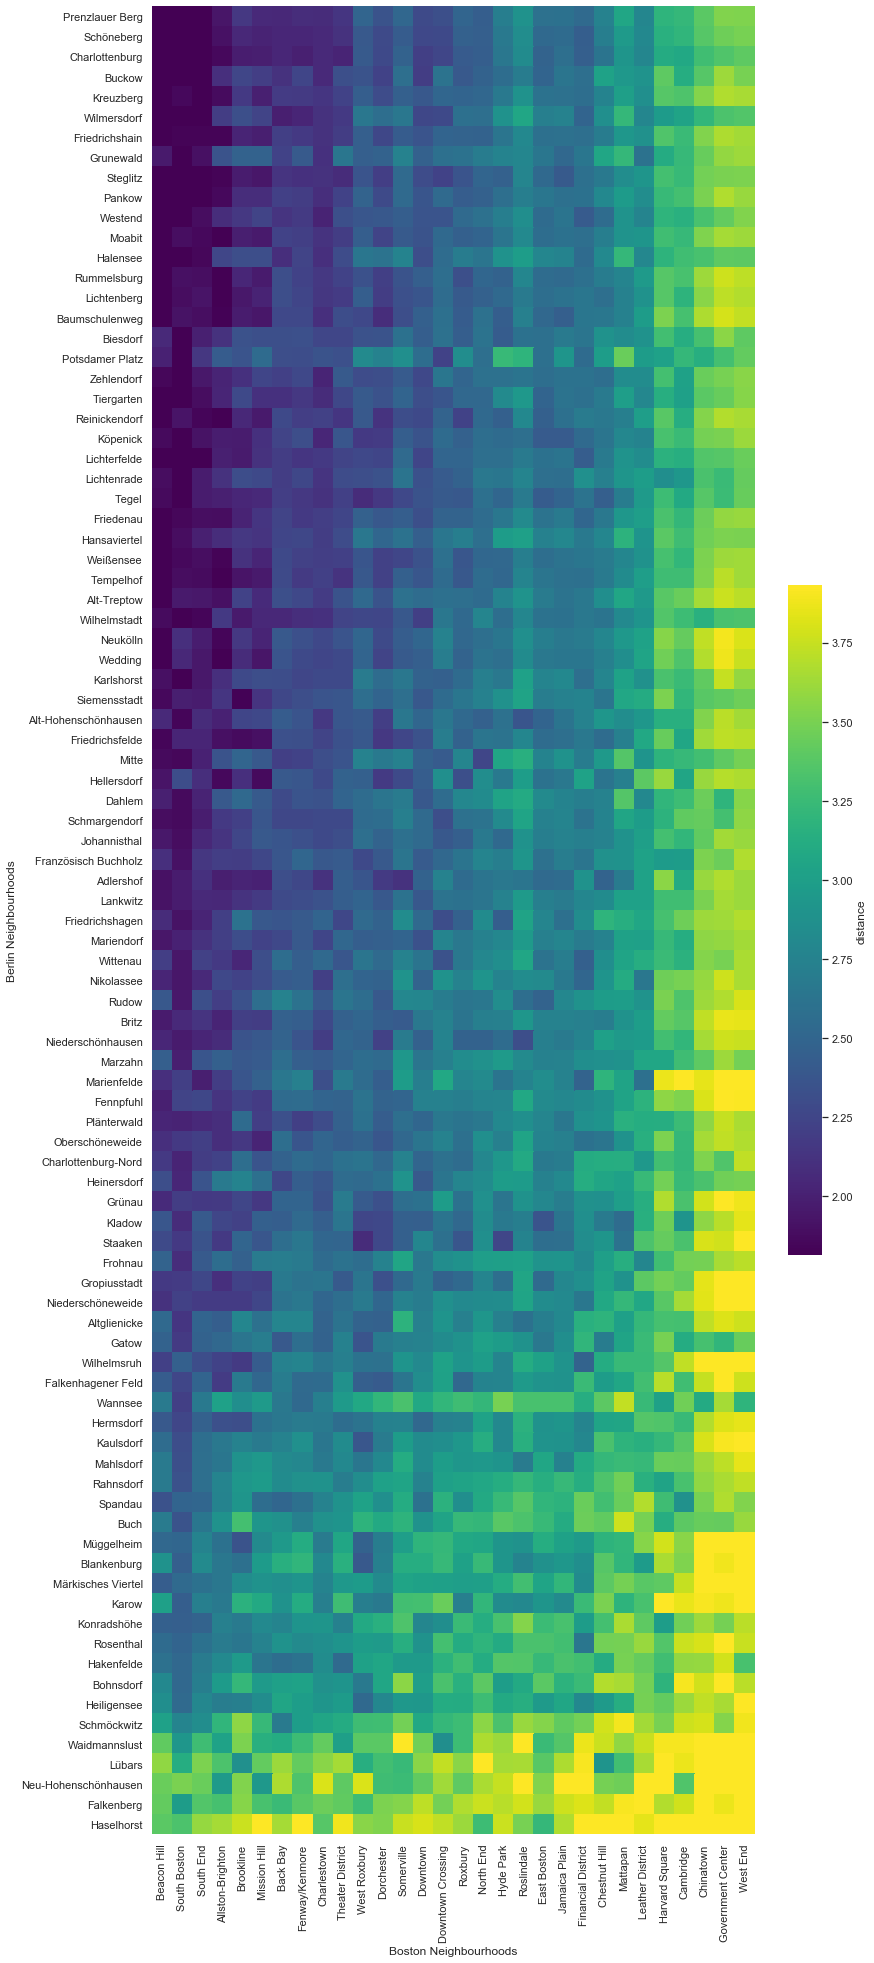

In [20]:
# distance heatmap
fix, ax = plt.subplots(figsize=(12,36))
sns.heatmap(dis_rel, annot=False, ax=ax, cmap='viridis', square=True, robust=True, cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
ax.set_xlabel('Boston Neighbourhoods')
ax.set_ylabel('Berlin Neighbourhoods')
plt.savefig('output/relative_heatmap.png', bbox_inches='tight')


## Reverse relative comparison out of curiosity

In [21]:
ber_closest_rel = pd.DataFrame(dis_rel.min(axis=1), columns=['distance'])
ber_closest_rel['neighbourhood'] = dis_rel.idxmin(axis=1)
ber_closest_rel['sigma'] = dis_rel.std(axis=1)

In [22]:
ber_closest_rel.loc[closest_rel['neighbourhood'].value_counts().index].head(35)

,distance,neighbourhood,sigma
Charlottenburg,1.582531,Beacon Hill,0.505302
Westend,1.661101,South Boston,0.474432
Kladow,2.074906,South Boston,0.448899
Wannsee,2.203323,South Boston,0.337387
Tegel,1.754543,South Boston,0.460358
Mitte,1.850666,South Boston,0.459484
Reinickendorf,1.725108,Allston-Brighton,0.542344
Adlershof,1.908770,Beacon Hill,0.518222
Steglitz,1.656433,Beacon Hill,0.536047
Baumschulenweg,1.713197,Beacon Hill,0.574193


In [23]:
closest_rel.sort_values(by=['neighbourhood']).head(35)

,distance,neighbourhood,sigma
Somerville,2.117025,Adlershof,0.361708
Dorchester,2.085518,Baumschulenweg,0.338584
Downtown,2.186124,Buckow,0.341984
South Boston,1.616284,Charlottenburg,0.372860
South End,1.697665,Charlottenburg,0.421029
Fenway/Kenmore,2.000705,Charlottenburg,0.363437
Theater District,2.026203,Charlottenburg,0.356715
Government Center,3.189427,Dahlem,0.271961
Mission Hill,1.866061,Hellersdorf,0.400314
Mattapan,2.553599,Kladow,0.301913
